## Homework 5 :  Physics 403, S25
Aidan Meador-Woodruff (ameadorw@ur.rochester.edu)

Due: Friday 21 March, 2025

In [ ]:
# Import statements
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import cumulative_trapezoid
from scipy.optimize import minimize
from scipy import special 

### Problem 1 : Credible and Confidence Intervals
*We are given a dataset with a linear hypothesis.*

---
*a).* We assume a single parameter $y=f(x)=mx$ where $m$ is an unknown slope. We wish to plot the Bayesian posterior PDF assuming a prior that enforces positive $m$ and compare it to one that does not.

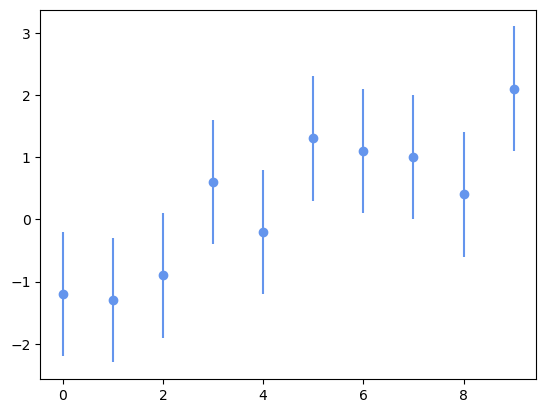

In [15]:
# Import the data and visualize it.
data = np.loadtxt("data_HW5.txt").transpose()
x,y, dy = data
plt.errorbar(x,y,yerr=dy, fmt='o',color='cornflowerblue',label='Dataset 1');


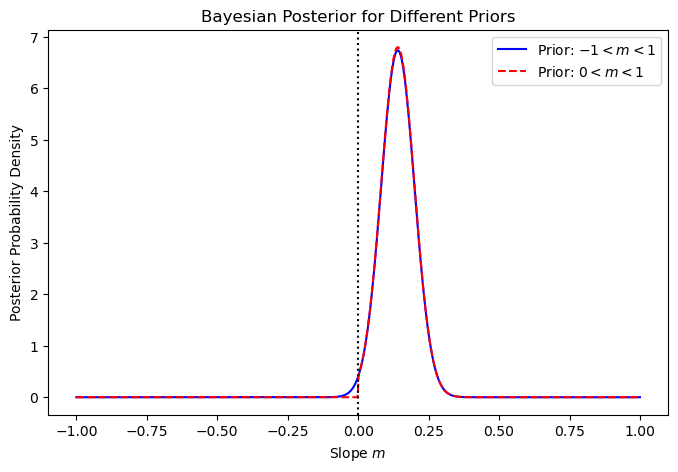

In [ ]:
# Define likelihood function
def log_likelihood(m):
    model = m * x
    return -0.5 * np.sum(((y - model) / dy) ** 2)

# Define priors
def flat_prior(m, prior_type):
    if prior_type == "m > 0":
        return 1.0 if 0 < m < 1 else 0.0
    elif prior_type == "symmetric":
        return 1.0 if -1 < m < 1 else 0.0

# Compute posterior
m_values = np.linspace(-1, 1, 500)
posterior_m_gt_0 = np.array([np.exp(log_likelihood(m)) * flat_prior(m, "m > 0") for m in m_values])
posterior_symmetric = np.array([np.exp(log_likelihood(m)) * flat_prior(m, "symmetric") for m in m_values])

# Normalize the posterior
posterior_m_gt_0 /= np.trapezoid(posterior_m_gt_0, m_values)
posterior_symmetric /= np.trapezoid(posterior_symmetric, m_values)

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(m_values, posterior_symmetric, label=r'Prior: $-1 < m < 1$', color='blue')
plt.plot(m_values, posterior_m_gt_0, label=r'Prior: $0 < m < 1$', color='red', linestyle='dashed')
plt.axvline(0, color='black', linestyle='dotted')
plt.xlabel('Slope $m$')
plt.ylabel('Posterior Probability Density')
plt.legend()
plt.title("Bayesian Posterior for Different Priors")
plt.show()

*b).* 

68% credible interval: (np.float64(0.08416833667334668), np.float64(0.2004008016032064))
90% credible interval: (np.float64(0.04809619238476953), np.float64(0.23847695390781562))


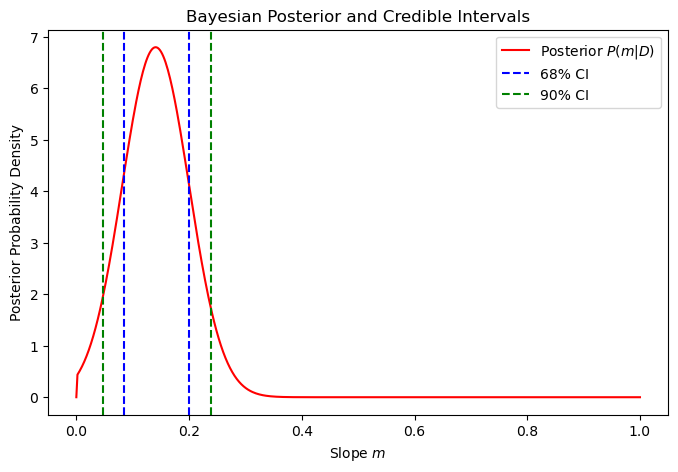

In [16]:
# Define likelihood function
def log_likelihood(m):
    model = m * x
    return -0.5 * np.sum(((y - model) / dy) ** 2)

# Define prior (non-negative m)
def flat_prior(m):
    return 1.0 if 0 < m < 1 else 0.0

# Compute posterior
m_values = np.linspace(0, 1, 500)  # Only positive m
posterior = np.array([np.exp(log_likelihood(m)) * flat_prior(m) for m in m_values])

# Normalize posterior
posterior /= np.trapezoid(posterior, m_values)

# Compute cumulative distribution function (CDF)
cdf = cumulative_trapezoid(posterior, m_values, initial=0)
cdf /= cdf[-1]  # Normalize to range [0,1]

# Function to find credible interval
def credible_interval(credibility):
    lower_idx = np.searchsorted(cdf, (1 - credibility) / 2)
    upper_idx = np.searchsorted(cdf, 1 - (1 - credibility) / 2)
    return m_values[lower_idx], m_values[upper_idx]

# Compute 68% and 90% credible intervals
ci_68 = credible_interval(0.68)
ci_90 = credible_interval(0.90)

# Print results
print(f"68% credible interval: {ci_68}")
print(f"90% credible interval: {ci_90}")

# Plot posterior with intervals
plt.figure(figsize=(8, 5))
plt.plot(m_values, posterior, label=r'Posterior $P(m | D)$', color='red')
plt.axvline(ci_68[0], color='blue', linestyle='dashed', label="68% CI")
plt.axvline(ci_68[1], color='blue', linestyle='dashed')
plt.axvline(ci_90[0], color='green', linestyle='dashed', label="90% CI")
plt.axvline(ci_90[1], color='green', linestyle='dashed')
plt.xlabel('Slope $m$')
plt.ylabel('Posterior Probability Density')
plt.title("Bayesian Posterior and Credible Intervals")
plt.legend()
plt.show()


In [21]:
def upper_limit(posterior, m_values, credibility):
    cdf = np.cumsum(posterior) / np.sum(posterior)
    upper_idx = np.searchsorted(cdf, credibility)
    return m_values[upper_idx]

# Compute upper limits
ul_68 = upper_limit(posterior_m_gt_0, m_values, 0.68)
ul_90 = upper_limit(posterior_m_gt_0, m_values, 0.90)

print(f"68% upper limit: {ul_68}")
print(f"90% upper limit: {ul_90}")

68% upper limit: 0.5851703406813626
90% upper limit: 0.6092184368737474


Best-fit slope: 0.1407017485404561
Δχ² between best-fit and m = 0: 5.642140350877184


<>:27: SyntaxWarning: invalid escape sequence '\c'
<>:27: SyntaxWarning: invalid escape sequence '\c'
/var/folders/1l/378_p_7n3w1cddmhf1mkkw2h0000gn/T/ipykernel_1430/3265419130.py:27: SyntaxWarning: invalid escape sequence '\c'
  plt.title("Frequentist $\chi^2$ Fit")


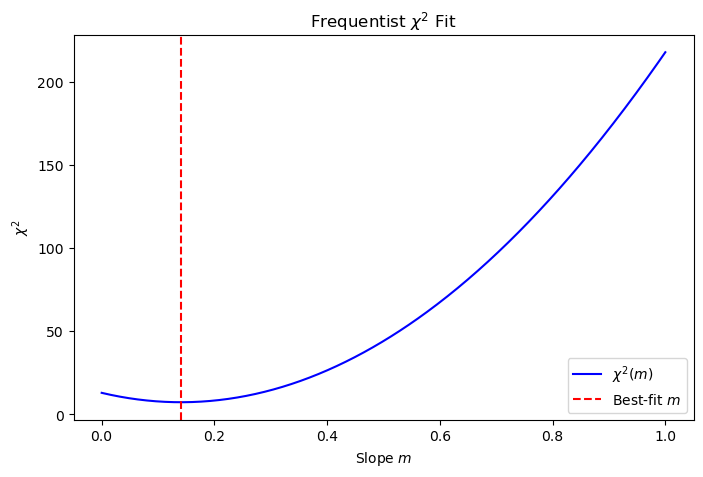

In [18]:

# Define chi^2 function
def chi2(m):
    model = m * x
    return np.sum(((y - model) / dy) ** 2)

# Compute chi^2 for different m values
chi2_values = np.array([chi2(m) for m in m_values])

# Find best-fit m
result = minimize(chi2, x0=0.5, bounds=[(0, 1)])  # Start at m=0.5, enforce non-negative constraint
m_best = result.x[0]
chi2_min = result.fun

# Compute delta chi^2
delta_chi2 = chi2(0) - chi2_min

print(f"Best-fit slope: {m_best}")
print(f"Δχ² between best-fit and m = 0: {delta_chi2}")

# Plot chi^2 curve
plt.figure(figsize=(8, 5))
plt.plot(m_values, chi2_values, label=r'$\chi^2(m)$', color='blue')
plt.axvline(m_best, color='red', linestyle='dashed', label=r'Best-fit $m$')
plt.xlabel('Slope $m$')
plt.ylabel(r'$\chi^2$')
plt.legend()
plt.title("Frequentist $\chi^2$ Fit")
plt.show()


<>:36: SyntaxWarning: invalid escape sequence '\D'
<>:36: SyntaxWarning: invalid escape sequence '\D'
/var/folders/1l/378_p_7n3w1cddmhf1mkkw2h0000gn/T/ipykernel_1430/1453862251.py:36: SyntaxWarning: invalid escape sequence '\D'
  plt.title("Feldman-Cousins $\Delta \chi^2$ Distribution")


Critical Δχ² for 68%: 0.23678526784231876
Critical Δχ² for 90%: 1.7006757722023487


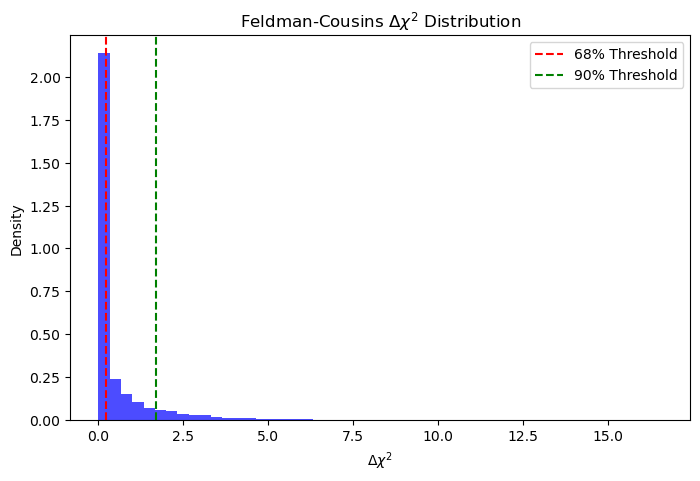

In [19]:
# Number of pseudo-experiments
n_experiments = 10000
sigma_y_fixed = 1.0  # Given in the problem
x_fixed = np.linspace(1, 10, 10)  # Simulated x values

best_fit_slopes = []
delta_chi2_values = []

# Run pseudo-experiments
for _ in range(n_experiments):
    y_sim = np.random.normal(0 * x_fixed, sigma_y_fixed)  # Generate pseudo-data for m=0
    def chi2_sim(m): return np.sum(((y_sim - m * x_fixed) / sigma_y_fixed) ** 2)
    
    # Best-fit slope
    result = minimize(chi2_sim, x0=0.5, bounds=[(0, 1)])
    m_fit = result.x[0]
    best_fit_slopes.append(m_fit)
    
    # Compute Δχ²
    delta_chi2_values.append(chi2_sim(0) - chi2_sim(m_fit))

# Find the critical Δχ² thresholds
delta_chi2_68 = np.percentile(delta_chi2_values, 68)
delta_chi2_90 = np.percentile(delta_chi2_values, 90)

print(f"Critical Δχ² for 68%: {delta_chi2_68}")
print(f"Critical Δχ² for 90%: {delta_chi2_90}")

# Histogram of Δχ² values
plt.figure(figsize=(8, 5))
plt.hist(delta_chi2_values, bins=50, density=True, alpha=0.7, color='blue')
plt.axvline(delta_chi2_68, color='red', linestyle='dashed', label="68% Threshold")
plt.axvline(delta_chi2_90, color='green', linestyle='dashed', label="90% Threshold")
plt.xlabel(r'$\Delta \chi^2$')
plt.ylabel('Density')
plt.title("Feldman-Cousins $\Delta \chi^2$ Distribution")
plt.legend()
plt.show()


In [20]:
# Compute Δχ² from the actual data
chi2_real = lambda m: np.sum(((y - m * x) / dy) ** 2)
result_real = minimize(chi2_real, x0=0.5, bounds=[(0, 1)])
m_best_real = result_real.x[0]
delta_chi2_obs = chi2_real(0) - chi2_real(m_best_real)

# Compute confidence level
confidence = np.mean(np.array(delta_chi2_values) < delta_chi2_obs)

print(f"Observed Δχ²: {delta_chi2_obs}")
print(f"Confidence level for excluding m=0: {confidence:.3f} ({confidence * 100:.1f}%)")


Observed Δχ²: 5.642140350877184
Confidence level for excluding m=0: 0.990 (99.0%)
